In [2]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import xgboost as xgb
import lightgbm as lgb

In [3]:
usd = pd.read_csv("data for modeling.csv")
usd

,open,close,hist_close,tick_vol,momentum_kama,others_cr,trend_ema_fast,trend_ema_slow,trend_ichimoku_a,trend_ichimoku_b,...,volume_vwap,date_time,month_sin,month_cos,hour_sin,hour_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos
0,1.02370,1.02170,0.00000,-0.952129,0.000000,-1.336836,0.000000,0.000000,0.000000,0.000000,...,0.000000,2008-06-11 08:00:00,1.224647e-16,1.224647e-16,8.660254e-01,8.660254e-01,0.790776,0.790776,0.974928,0.974928
1,1.02190,1.02200,1.02170,-0.957048,0.000000,-1.336836,0.000000,0.000000,0.000000,1.022600,...,0.000000,2008-06-11 09:00:00,1.224647e-16,1.224647e-16,7.071068e-01,7.071068e-01,0.790776,0.790776,0.974928,0.974928
2,1.02210,1.01960,1.02200,-0.953769,0.000000,-1.334670,0.000000,0.000000,0.000000,1.022600,...,0.000000,2008-06-11 10:00:00,1.224647e-16,1.224647e-16,5.000000e-01,5.000000e-01,0.790776,0.790776,0.974928,0.974928
3,1.01970,1.01920,1.01960,-0.920566,0.000000,-1.351993,0.000000,0.000000,0.000000,1.021750,...,0.000000,2008-06-11 11:00:00,1.224647e-16,1.224647e-16,2.588190e-01,2.588190e-01,0.790776,0.790776,0.974928,0.974928
4,1.01930,1.01890,1.01920,-1.019356,0.000000,-1.354880,0.000000,0.000000,0.000000,1.020600,...,0.000000,2008-06-11 12:00:00,1.224647e-16,1.224647e-16,1.224647e-16,1.224647e-16,0.790776,0.790776,0.974928,0.974928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.38337,1.38220,1.38337,-0.362259,1.382059,1.273655,1.382132,1.381847,1.382520,1.381295,...,1.382099,2024-07-26 19:00:00,-5.000000e-01,-5.000000e-01,-9.659258e-01,-9.659258e-01,-0.848644,-0.848644,-0.433884,-0.433884
99996,1.38219,1.38332,1.38220,-0.218788,1.382061,1.265210,1.382142,1.381874,1.382520,1.381295,...,1.382165,2024-07-26 20:00:00,-5.000000e-01,-5.000000e-01,-8.660254e-01,-8.660254e-01,-0.848644,-0.848644,-0.433884,-0.433884
99997,1.38332,1.38376,1.38332,-0.332745,1.382126,1.273294,1.382323,1.381981,1.382520,1.381540,...,1.382258,2024-07-26 21:00:00,-5.000000e-01,-5.000000e-01,-7.071068e-01,-7.071068e-01,-0.848644,-0.848644,-0.433884,-0.433884
99998,1.38376,1.38308,1.38376,-0.528685,1.382254,1.276470,1.382544,1.382112,1.382520,1.381540,...,1.382376,2024-07-26 22:00:00,-5.000000e-01,-5.000000e-01,-5.000000e-01,-5.000000e-01,-0.848644,-0.848644,-0.433884,-0.433884


In [4]:
usd.set_index('date_time', inplace=True)

In [18]:
target = usd.close
features = usd.drop(columns=['close'])

x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.05, shuffle=False)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.055, shuffle=False)

print(x_train.shape, y_train.shape, x_val.shape,
    y_val.shape, x_test.shape, y_test.shape)

(89775, 35) (89775,) (5225, 35) (5225,) (5000, 35) (5000,)


In [6]:
x_val.head()

,open,hist_close,tick_vol,momentum_kama,others_cr,trend_ema_fast,trend_ema_slow,trend_ichimoku_a,trend_ichimoku_b,trend_ichimoku_base,...,volume_vpt,volume_vwap,month_sin,month_cos,hour_sin,hour_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos
date_time,,,,,,,,,,,,,,,,,,,,,
2022-12-05 16:00:00,1.34233,1.34232,1.194196,1.341717,0.977361,1.341978,1.342764,1.343682,1.345275,1.345275,...,1.273275,1.341815,-2.449294e-16,-2.449294e-16,-0.866025,-0.866025,0.848644,0.848644,0.0,0.0
2022-12-05 17:00:00,1.34776,1.34680,2.939622,1.342290,1.009697,1.342720,1.343063,1.344207,1.345275,1.345275,...,1.307732,1.342146,-2.449294e-16,-2.449294e-16,-0.965926,-0.965926,0.848644,0.848644,0.0,0.0
2022-12-05 18:00:00,1.35172,1.35172,1.757012,1.343891,1.045209,1.344104,1.343705,1.345605,1.345370,1.345370,...,1.373926,1.343821,-2.449294e-16,-2.449294e-16,-1.000000,-1.000000,0.848644,0.848644,0.0,0.0
2022-12-05 19:00:00,1.35698,1.35698,0.635069,1.346664,1.083175,1.346085,1.344688,1.348310,1.348075,1.348075,...,1.423882,1.345440,-2.449294e-16,-2.449294e-16,-0.965926,-0.965926,0.848644,0.848644,0.0,0.0
2022-12-05 20:00:00,1.35775,1.35775,0.489139,1.348972,1.088733,1.347880,1.345656,1.348745,1.348510,1.348510,...,1.428323,1.346489,-2.449294e-16,-2.449294e-16,-0.866025,-0.866025,0.848644,0.848644,0.0,0.0


In [7]:
def bic_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    n = X.shape[0]
    k = X.shape[1] + 1
    residual_sum_of_squares = np.sum((y - y_pred) ** 2)
    bic = n * np.log(residual_sum_of_squares / n) + k * np.log(n)
    return -bic

In [8]:
tscv = TimeSeriesSplit(n_splits=5)

In [8]:
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('regressor', LinearRegression())
])

param_grid = {
    'regressor__fit_intercept': [True, False]
    }

grid_search = GridSearchCV(pipe, param_grid, cv=tscv,
                           scoring=bic_scorer, n_jobs=-1)
grid_search.fit(x_train, y_train)

# Extract best model
best_lr = grid_search.best_estimator_

lr_pred = best_lr.predict(x_val)
lr_rmse = root_mean_squared_error(y_val, lr_pred)
lr_rmse

0.0011197531049178524

Lasso may be a better choice than ridge regression becuase it shrink some coefficients to zero, thereby removing them from the model.

In [19]:
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('regressor', Lasso())
])


param_grid = {
    'regressor__alpha': np.logspace(-4, 4, 50)
    }

grid_search = GridSearchCV(pipe, param_grid, cv=tscv,
                           scoring=bic_scorer, n_jobs=-1)
grid_search.fit(x_train, y_train)


# Final model with the best Lasso alpha
best_lasso = grid_search.best_estimator_

las_pred = best_lasso.predict(x_val)
las_reg_rmse = root_mean_squared_error(y_val, las_pred)
print(las_reg_rmse)

0.001127820844782672


In [20]:
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('regressor', Ridge())
])

param_grid = {
    'regressor__alpha': np.logspace(-4, 4, 50)
}

grid_search = GridSearchCV(pipe, param_grid, cv=tscv,
                           scoring=bic_scorer, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_ridge = grid_search.best_estimator_

ridge_pred = best_lasso.predict(x_val)
ridge_reg_rmse = root_mean_squared_error(y_val, ridge_pred)
print(ridge_reg_rmse)

0.001127820844782672


## Ensemble and Boosting

In [21]:
# Extract a subset of the training data (10%)
x_subset, _, y_subset, _ = (train_test_split(
    x_train, y_train, train_size=0.1, shuffle=False))

In [28]:
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state = 42))
])

param_grid = {
    'regressor__n_estimators': [100, 200, 500],
    'regressor__max_depth': [10, 20, 30, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Gridsearch parameter for best model
grid_search = GridSearchCV(
    pipe, param_grid, cv=TimeSeriesSplit(n_splits=3), scoring=bic_scorer, n_jobs=-1, verbose=True)
grid_search.fit(x_subset, y_subset)

# Extract best model
best_rf = grid_search.best_estimator_

# retrain on whole dataset
best_rf.fit(x_train, y_train)

rf_pred = best_rf.predict(x_val)
rf_rmse = root_mean_squared_error(y_val, rf_pred)
rf_rmse

Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

In [22]:
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_grid = {
    'regressor__n_estimators': [100, 200, 500],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.3],
    'regressor__subsample': [0.7, 0.8, 1.0]
}

# Gridsearch parameters for best model
grid_search = GridSearchCV(
    pipe, param_grid, cv=tscv, scoring=bic_scorer, n_jobs=-1, verbose=True)
grid_search.fit(x_subset, y_subset)

# Extract best model
best_xgb = grid_search.best_estimator_

# retrain on whole dataset
best_xgb.fit(x_train, y_train)

xgb_pred = best_xgb.predict(x_val)
xgb_rmse = root_mean_squared_error(y_val, xgb_pred)
xgb_rmse

Fitting 5 folds for each of 81 candidates, totalling 405 fits


0.0018133385418321768

In [23]:
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('regressor', lgb.LGBMRegressor(random_state=42))
])

param_grid = {
    'regressor__n_estimators': [100, 200, 500],
    'regressor__learning_rate': [0.01, 0.1, 0.3],
    'regressor__max_depth': [10, 20, 30, -1],
    'regressor__num_leaves': [31, 50, 100],
    'regressor__min_child_samples': [10, 20, 30],
}

# Gridsearch parameters for best model
grid_search = GridSearchCV(
    pipe, param_grid, cv=tscv, scoring=bic_scorer, n_jobs=-1, verbose=True)
grid_search.fit(x_subset, y_subset)

# Extract best model
best_lgb = grid_search.best_estimator_

# retrain on whole dataset
best_lgb.fit(x_train, y_train)


lgb_pred = best_lgb.predict(x_val)
lgb_rmse = root_mean_squared_error(y_val, lgb_pred)
lgb_rmse

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7013
[LightGBM] [Info] Number of data points in the train set: 8977, number of used features: 35
[LightGBM] [Info] Start training from score 1.136182
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7019
[LightGBM] [Info] Number of data points in the train set: 89775, number of used features: 35
[LightGBM] [Info] Start training from score 1.190211


0.001654903552893256

In [24]:
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('regressor', SVR())
])


param_grid = {
    'regressor__C': [0.1, 1, 10],
    'regressor__gamma': ['scale', 'auto'],
    'regressor__kernel': ['poly', 'sigmoid', 'rbf']
}

grid_search = GridSearchCV(pipe, param_grid, cv=tscv,
                           scoring=bic_scorer, n_jobs=-1)
grid_search.fit(x_train, y_train)

best_svr = grid_search.best_estimator_
svr_pred = best_svr.predict(x_val)
svr_rmse = root_mean_squared_error(y_val, svr_pred)
svr_rmse


0.05711765273003893

# Time Series 

In [ ]:
def arima_gridsearch(y, p_values, d_values, q_values):
    best_score = float("inf")
    best_cfg = None
    best_arima_model = None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        order = (p, d, q)
        arima_model = ARIMA(y, order = order)
        arima_model_fit = arima_model.fit()
        bic = arima_model_fit.bic

        # we want to minimize bic
        if bic < best_score:
            best_score = bic
            best_cfg = order
            best_arima_model = arima_model_fit
    return best_arima_model, best_cfg

In [ ]:
import warnings
warnings.filterwarnings('ignore')

p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)

best_arima_model, best_cfg = arima_gridsearch(
    y_train, p_values, d_values, q_values)

print(best_arima_model.summary())

warnings.resetwarnings()

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                89775
Model:                 ARIMA(4, 1, 0)   Log Likelihood              459423.395
Date:                Tue, 20 Aug 2024   AIC                        -918836.790
Time:                        19:09:12   BIC                        -918789.765
Sample:                             0   HQIC                       -918822.450
                              - 89775                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0157      0.002    -10.056      0.000      -0.019      -0.013
ar.L2         -0.0113      0.002     -6.248      0.000      -0.015      -0.008
ar.L3         -0.0057      0.002     -3.041      0.0

In [ ]:
arima_pred = best_arima_model.forecast(steps = len(y_val))
arima_rmse = root_mean_squared_error(y_val, arima_pred)
arima_rmse

c:\Users\asoye\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\asoye\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


0.01632273057143548

# Regression with PCA

In [25]:
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('pca', PCA()),
    ('regressor', LinearRegression())
])

param_grid = {
    'pca__n_components': np.arange(1, 35),
    'regressor__fit_intercept': [True, False]
}

grid_search = GridSearchCV(pipe, param_grid, cv=tscv,
                           scoring=bic_scorer, n_jobs=-1)
grid_search.fit(x_train, y_train)

# Extract best model
best_n_components = grid_search.best_params_['pca__n_components']
best_pca_lr = grid_search.best_estimator_
print(f"Optimal number of components for Linear: {best_n_components}")

pca_lr_pred = best_pca_lr.predict(x_val)
pca_lr_rmse = root_mean_squared_error(y_val, pca_lr_pred)
print(pca_lr_rmse)

Optimal number of components for Linear: 32
0.001119753128966694


In [26]:
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('pca', PCA()),
    ('regressor', Lasso())
])

param_grid = {
    'pca__n_components': np.arange(1, 31),
    'regressor__alpha': np.logspace(-4, 4, 50)
}

grid_search = GridSearchCV(pipe, param_grid, cv=tscv,
                           scoring=bic_scorer, n_jobs=-1)
grid_search.fit(x_train, y_train)

# Extract best model
best_n_components = grid_search.best_params_['pca__n_components']
best_pca_lasso = grid_search.best_estimator_
print(f"Optimal number of components for Lasso: {best_n_components}")

pca_lasso_pred = best_pca_lasso.predict(x_val)
pca_lasso_rmse = root_mean_squared_error(y_val, pca_lasso_pred)
print(pca_lasso_rmse)

Optimal number of components for Lasso: 15
0.001888233212705921


In [27]:
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('pca', PCA()),
    ('regressor', Ridge())
])

param_grid = {
    'pca__n_components': np.arange(1, 31),
    'regressor__alpha': np.logspace(-4, 4, 50)
}

grid_search = GridSearchCV(pipe, param_grid, cv=tscv,
                           scoring=bic_scorer, n_jobs=-1)
grid_search.fit(x_train, y_train)

# Extract best model
best_n_components = grid_search.best_params_['pca__n_components']
best_pca_ridge = grid_search.best_estimator_
print(f"Optimal number of components for Ridge: {best_n_components}")

pca_ridge_pred = best_pca_ridge.predict(x_val)
pca_ridge_rmse = root_mean_squared_error(y_val, pca_ridge_pred)
print(pca_ridge_rmse)

Optimal number of components for Ridge: 29
0.0011197512720526606


Linear Regression

Linear Regression Without Historical Closing

In [9]:
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('regressor', LinearRegression())
])

param_grid = {
    'regressor__fit_intercept': [True, False]
}

grid_search = GridSearchCV(pipe, param_grid, cv=tscv,
                           scoring=bic_scorer, n_jobs=-1)
grid_search.fit(x_train.drop(columns='hist_close'), y_train)

# Extract best model
best_lr_no_hist_close = grid_search.best_estimator_

lr_pred_no_hist_close = best_lr_no_hist_close.predict(x_val.drop(columns='hist_close'))
lr_rmse_no_hist_close = root_mean_squared_error(y_val, lr_pred_no_hist_close)
lr_rmse_no_hist_close

0.0011194048414831035

Linear Regression - P-Value Test

In [9]:
# fit statsmodel linear regression model
X = sm.add_constant(x_train)
estimator = sm.OLS(y_train, X)
usd_linear_model = estimator.fit()

# Extract the pvalues for each feature
features = ['const']
features += (list(x_train.columns))
p_values = []
for value in range(len(features)):
    p_values.append(usd_linear_model.pvalues[value])

features = dict((zip(features, p_values)))
p_values = pd.DataFrame(features.items(), columns = ['features', 'p_values'])
p_values[p_values['p_values'] < 0.05].loc[1:]

C:\Users\asoye\AppData\Local\Temp\ipykernel_13244\2258136836.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_values.append(usd_linear_model.pvalues[value])


,features,p_values
1,open,2.153556e-210
2,hist_close,8.051911e-07
5,others_cr,1.287664e-10
6,trend_ema_fast,2.383247e-03
7,trend_ema_slow,3.463047e-02
10,trend_ichimoku_base,4.335708e-02
12,trend_sma_fast,1.973291e-03
24,volatility_kcl,1.987325e-03


In [10]:
# Extract the features with p-values less than 0.05
feature_extract = dict((k,v) for k, v in features.items() if v <0.05)
pvalue_x_train = x_train[list(feature_extract.keys())[1:]]
pvalue_x_val = x_val[list(feature_extract.keys())[1:]]

pipe = Pipeline([
    ('sc', StandardScaler()),
    ('regressor', LinearRegression())
])

param_grid = {
    'regressor__fit_intercept': [True, False]
}

grid_search = GridSearchCV(pipe, param_grid, cv=tscv,
                            scoring=bic_scorer, n_jobs=-1)
grid_search.fit(pvalue_x_train, y_train)

# Extract best model
best_lr_pvalue = grid_search.best_estimator_

lr_pred_pvalue = best_lr_pvalue.predict(pvalue_x_val)
lr_rmse_pvalue = root_mean_squared_error(y_val, lr_pred_pvalue)
lr_rmse_pvalue

0.0011194275753757933

Linear Regression - Recursive Feature Elimination

tried a list of 5,10,15,20,25,30, and 20 was selected, so trying a range between 16 and 21 - for number of features to select.

In [11]:
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('rfe', RFE(estimator = LinearRegression())),
    ('regressor', LinearRegression())
])

param_grid = {
    'rfe__n_features_to_select': np.arange(16,21),
    'regressor__fit_intercept': [True, False]
}

grid_search = GridSearchCV(pipe, param_grid, cv=tscv,
                           scoring=bic_scorer, n_jobs=-1)
grid_search.fit(x_train, y_train)

# Extract best model
best_lr_rfe = grid_search.best_estimator_

# Extract best number of features
best_rfe = best_lr_rfe.named_steps['rfe']
best_number_of_features = best_rfe.n_features_
print(f"The best number of features to select: {best_number_of_features}")

# Use this to extract the names of the selected features
selected_features_mask = best_rfe.support_

feature_ranking = best_rfe.ranking_
print(f"Feature rankings: {feature_ranking}")



lr_pred_rfe = best_lr_rfe.predict(x_val)
lr_rmse_rfe = root_mean_squared_error(y_val, lr_pred_rfe)
lr_rmse_rfe

The best number of features to select: 20
Feature rankings: [ 1  1 13  2  1  1  1  6  9  1  4  1  1 11  5  1  1  1  1  1  1  1  3  1
 12 15 10  1  1 14 16  8  7  1  1]


0.0011196677898037744

## DenseNet

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(128, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

seq_pred = model.predict(x_val)
seq_rmse = root_mean_squared_error(y_val, seq_pred)
print(seq_rmse)

c:\Users\asoye\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0554 - val_loss: 0.0233
Epoch 2/100
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 8.3048e-04 - val_loss: 0.0039
Epoch 3/100
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.5754e-04 - val_loss: 0.0020
Epoch 4/100
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.2254e-04 - val_loss: 7.7266e-04
Epoch 5/100
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 7.9285e-05 - val_loss: 6.3013e-04
Epoch 6/100
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 6.3896e-05 - val_loss: 4.7135e-04
Epoch 7/100
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 5.3350e-05 - val_loss: 5.4026e-04
Epoch 8/100
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.5412e-05 - val_loss: 2.9584e-04
Epoch 9/100
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 3.9109e-05 - val_loss: 4.6788e-04
Epoch 10/100
2245/2245 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 4.1162e-05 - val_loss: 3.5130e-04
Epoch 11/100
2245/2245 ━━━━━━━━━━━━━━━━━

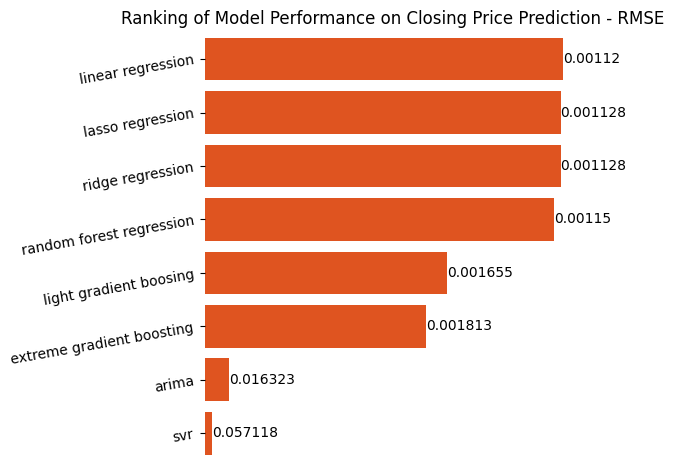

In [41]:

rmse_scores = {'model': ['linear regression', 'lasso regression', 'ridge regression', 
                         'random forest regression', 'light gradient boosting', 'extreme gradient boosting', 'arima',
                         'svr'
                        ],


                'scores': [lr_rmse, las_reg_rmse, ridge_reg_rmse,
                           0.00115,  lgb_rmse, xgb_rmse, 0.01632273057143548, svr_rmse

                            ]
                } # hard coding arima score cuz system restart resulted in lost variable. It'll take long to retrain unlike others. same for random forest.

rmse_scores = pd.DataFrame(rmse_scores)
# Plot inverse of the rmse to obtain rankings
ax = sns.barplot(data= rmse_scores, x = 1/rmse_scores['scores'], y = 'model', color = 'orangered')
plt.yticks(rotation = 10)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
ax.bar_label(ax.containers[0], labels = round(rmse_scores['scores'], 6))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.title('Ranking of Model Performance on Closing Price Prediction - RMSE')
plt.tight_layout();

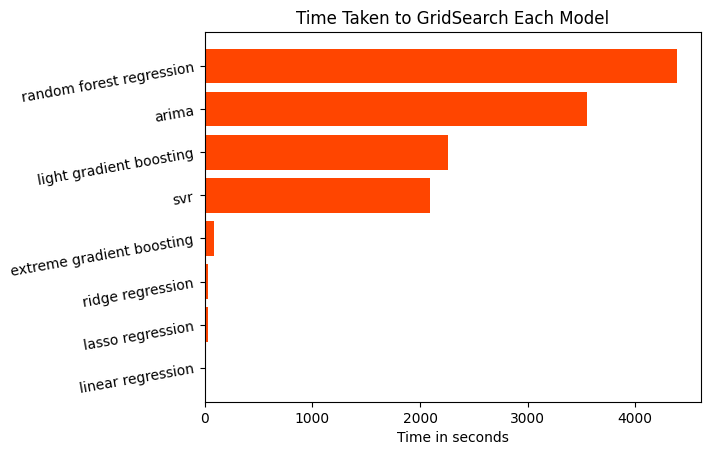

In [43]:
models = ['linear regression', 'lasso regression', 'ridge regression', 
        'extreme gradient boosting', 'svr', 'light gradient boosting', 'arima', 'random forest regression'
            ]

time = [3.5, 28.7, 30, 83, 2090, 2264, 3556, 4390]
ax = plt.barh(models, width=time, color = 'orangered')



plt.yticks(rotation = 10)



plt.xlabel('Time in seconds')



plt.title('Time Taken to GridSearch Each Model');

C:\Users\asoye\AppData\Local\Temp\ipykernel_9984\2817918090.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=rmse_scores, x=1 /


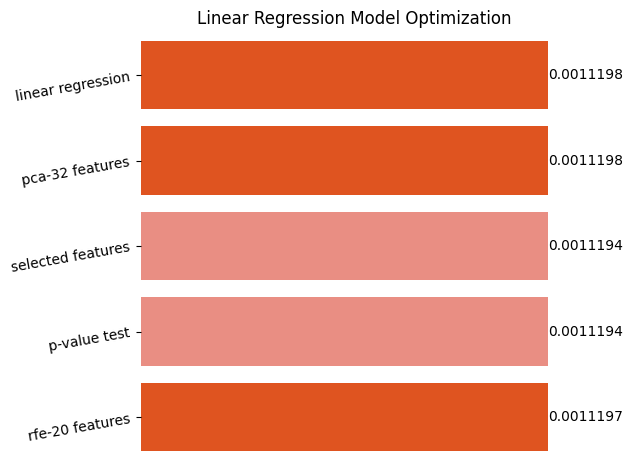

In [57]:
rmse_scores = {
    'model': ['linear regression', 'pca-32 features', 'selected features', 'p-value test', 'rfe-20 features'],
    'scores': [lr_rmse, pca_lr_rmse, lr_rmse_no_hist_close, lr_rmse_pvalue, lr_rmse_rfe]
}

rmse_scores = pd.DataFrame(rmse_scores)
colors = ['orangered'] * len(rmse_scores)
colors[2] = 'salmon'  # Custom color for specific bars
colors[3] = 'salmon'

# Create the bar plot with custom colors
ax = sns.barplot(data=rmse_scores, x=1 /
                rmse_scores['scores'], y='model', palette=colors)

# Add labels to each bar
for i, bar in enumerate(ax.patches):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2, round(rmse_scores['scores'][i], 7),
            va='center', ha='left', color='black')

# Customize plot appearance
plt.yticks(rotation=10)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.title('Linear Regression Model Optimization')
plt.tight_layout()
plt.show()

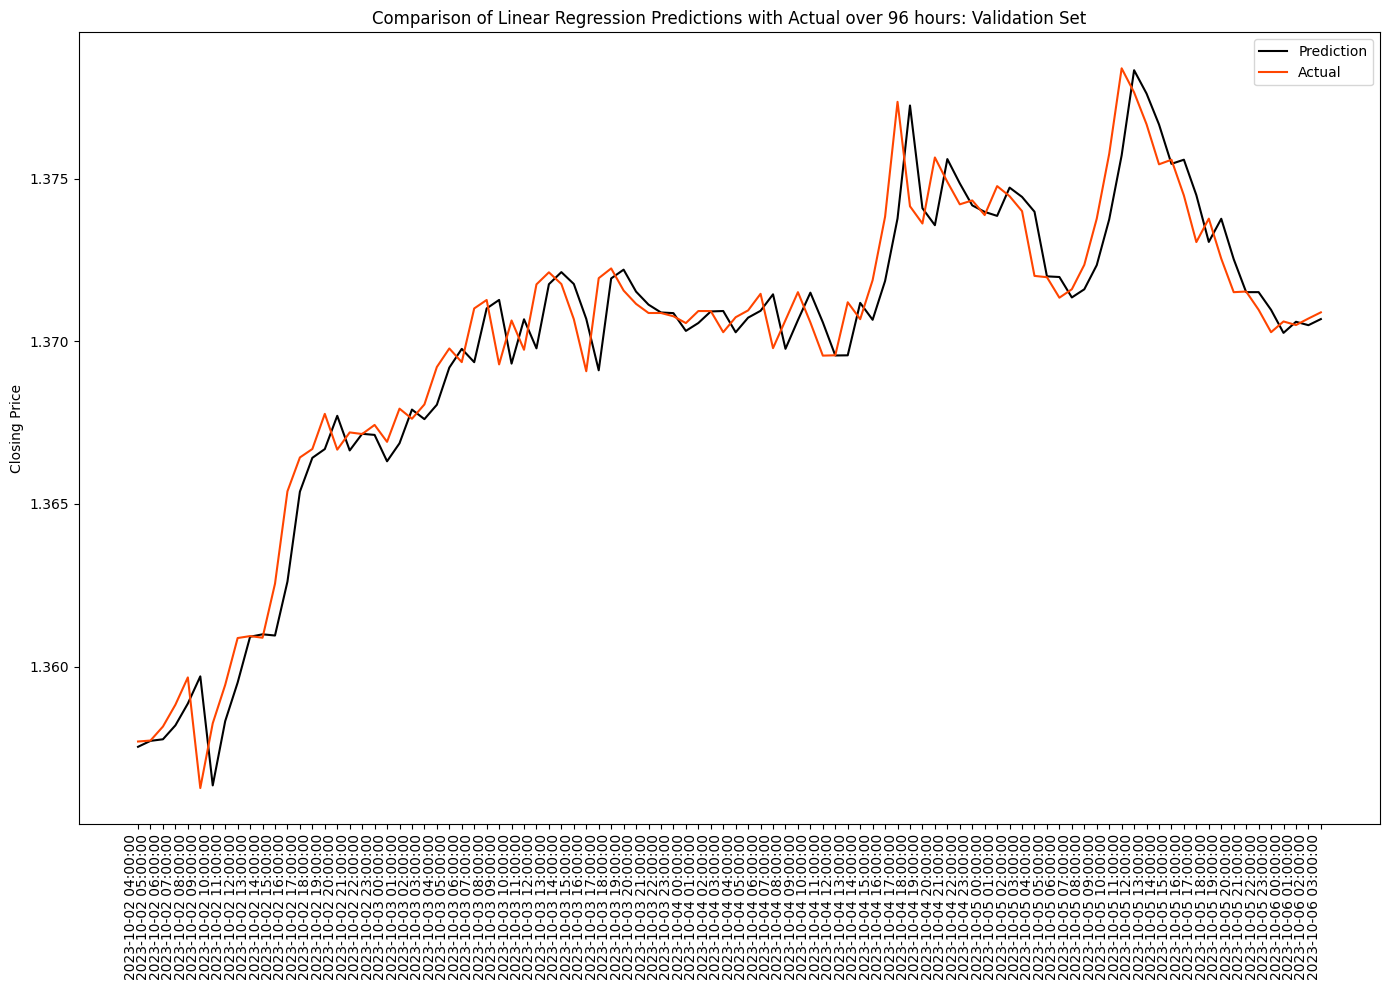

In [17]:
plt.figure(figsize=(14, 10))
plt.plot(lr_pred_pvalue[-96:], label='Prediction', color='black')
plt.plot(y_val[-96:], label = 'Actual', color = 'orangered')
plt.xticks(rotation = 90, ha = 'right')
plt.title('Comparison of Linear Regression Predictions with Actual over 96 hours: Validation Set')
plt.ylabel('Closing Price')
plt.legend()
plt.tight_layout();

In [61]:
pvalue_x_test = x_test[list(feature_extract.keys())[1:]]

lr_test_pred_pvalue = best_lr_pvalue.predict(pvalue_x_test)
lr_test_rmse_pvalue = root_mean_squared_error(y_test, lr_test_pred_pvalue)
lr_rmse_pvalue

0.0011194275753757933

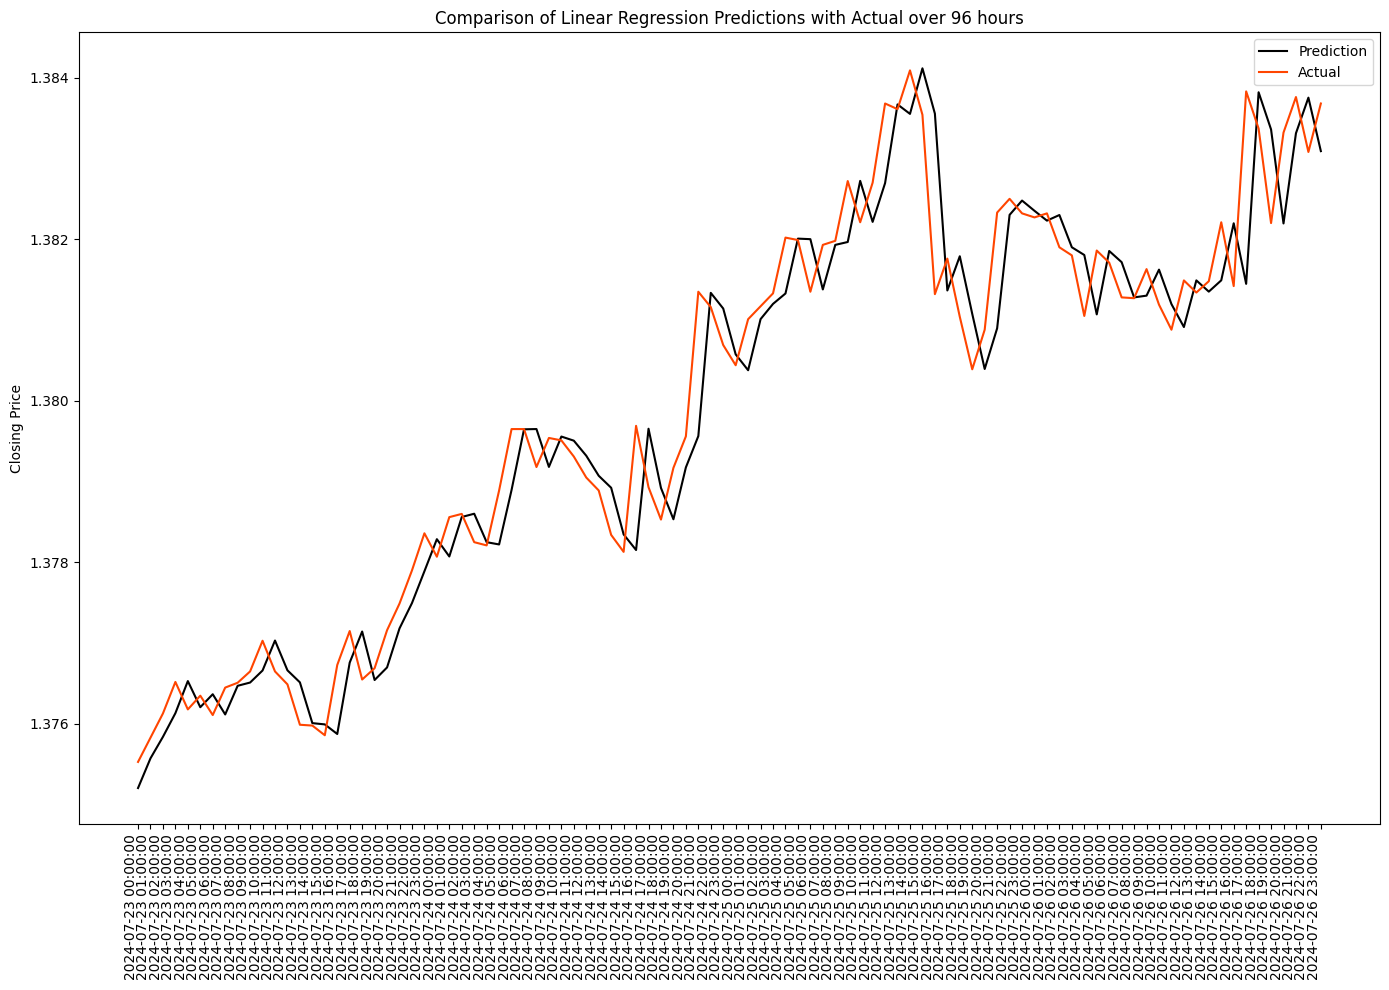

In [65]:
plt.figure(figsize=(14, 10))
plt.plot(lr_test_pred_pvalue[-96:], label='Prediction', color='black')
plt.plot(y_test[-96:], label='Actual', color='orangered')
plt.xticks(rotation=90, ha='right')
plt.title('Comparison of Linear Regression Predictions with Actual over 96 hours')
plt.ylabel('Closing Price')
plt.legend()
plt.tight_layout()

# Model Saving

In [67]:
import pickle
filename = 'best_model.pkl'
pickle.dump(best_lr_pvalue, open(filename, 'wb'))